In [ ]:
!pip install pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/imageprocessing')

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import pydicom

plt.set_cmap('gray')
%matplotlib inline

# Seeding
seed = 2019
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

IMG_DTYPE = np.float64
SEG_DTYPE = np.uint8

<Figure size 640x480 with 0 Axes>

In [ ]:
masks_path = os.path.join('train', 'masks')
training_path = os.path.join('train', 'patients')

In [ ]:
def imshow(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        tumor_volume = None

        image_path = os.path.join(self.path, "patients", id_name)
        mask_path = os.path.join(self.path, "masks")
        dicom_image = pydicom.dcmread(image_path)

        image = step1_preprocess_img_slice(dicom_image.pixel_array)

        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array

        image = np.multiply(image, np.clip(liver_mask, 0, 1))

        image = np.array(Image.fromarray(image).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path, 'merged_livertumors', id_name+'.jpg'))

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([self.image_size, self.image_size])).astype(IMG_DTYPE)
        mask = mask // 255

        mask = mask[:, :, np.newaxis]

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        files_batch = self.ids[index * self.batch_size: (index + 1) * self.batch_size]
        image = []
        mask = []
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,) * 3, axis=-1)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))


In [ ]:
# image_size =  256
# train_path = "train"
# batch_size = 8
# epochs = 30
# ## Training Ids
# images = []
# for file in os.listdir(os.path.join(train_path, "patients")):

#     images.append(file)


# ## Validation Data Size
# val_data_size = len(images)//5 # 20% validation Data
# # factor = 0
# valid_ids = images[:val_data_size]
# train_ids = images[val_data_size:]
# print(len(train_ids))

18617


We run this on 25% dataset for speed. Going to 50% can lead to OS error due to disconnection from drive.

In [ ]:
image_size = 256
train_path = "train"
batch_size = 8
epochs = 30

# Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
    images.append(file)

# Randomly select 25% of the data
random.seed(42)  # Set a seed for reproducibility
selected_ids = random.sample(images, int(0.25 * len(images)))

# Divide into training and validation sets
val_data_size = len(selected_ids) // 5  # 20% validation Data
valid_ids = selected_ids[:val_data_size]
train_ids = selected_ids[val_data_size:]

print(len(train_ids))

4654


In [ ]:
def step1_preprocess_img_slice(img_slc):
    img_slc[img_slc > 1200] = 0
    img_slc = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc

In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)


0


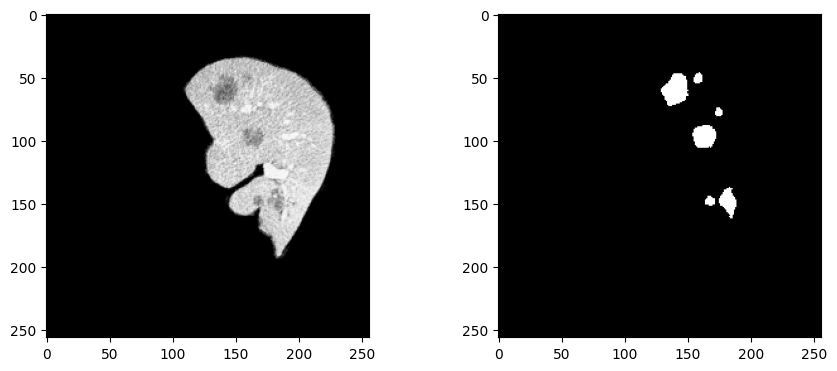

In [ ]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)

    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)

    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))

    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)

    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)

    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])

    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])

    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])

    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model = ResUNet()
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss=dice_coef_loss, metrics=["acc", dice_coef])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_56 (Ba  (None, 256, 256, 16)         64        ['conv2d_60[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_38 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_56

In [ ]:
# Train the model
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids) // batch_size
valid_steps = len(valid_ids) // batch_size

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/30
581/581 [==============================] - 7156s 12s/step - loss: 0.6114 - acc: 0.9795 - dice_coef: 0.3977 - val_loss: 0.8145 - val_acc: 0.9328 - val_dice_coef: 0.1855
Epoch 2/30
581/581 [==============================] - 907s 2s/step - loss: 0.4629 - acc: 0.9928 - dice_coef: 0.5361 - val_loss: 0.7656 - val_acc: 0.9513 - val_dice_coef: 0.2344
Epoch 3/30
581/581 [==============================] - 267s 460ms/step - loss: 0.5270 - acc: 0.9916 - dice_coef: 0.4644 - val_loss: 0.7977 - val_acc: 0.9343 - val_dice_coef: 0.2023
Epoch 4/30
581/581 [==============================] - 219s 377ms/step - loss: 0.5101 - acc: 0.9925 - dice_coef: 0.4899 - val_loss: 0.9870 - val_acc: 0.9924 - val_dice_coef: 0.0130
Epoch 5/30
581/581 [==============================] - 201s 347ms/step - loss: 0.5243 - acc: 0.9931 - dice_coef: 0.4757 - val_loss: 0.4896 - val_acc: 0.9922 - val_dice_coef: 0.5104
Epoch 6/30
581/581 [==============================] - 207s 354ms/step - loss: 0.5043 - acc: 0.9921 - dic

In [ ]:
# train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
# valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

# train_steps = len(train_ids) // batch_size
# valid_steps = len(valid_ids) // batch_size

# model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

In [ ]:
model.save('tumor_model_result.h5')  # creates a HDF5 file 'my_model.h5'
# model.save_weights("tumor_weights_final_50epochs.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
